In [13]:
## pip install lightgbm

In [14]:
## pip install catboost

In [15]:
## pip install ipywidgets

In [16]:
# pip install xgboost

In [17]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

In [18]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')

In [19]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


C:\Users\LIMJAE~1\AppData\Local\Temp/ipykernel_22708/3983262534.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(

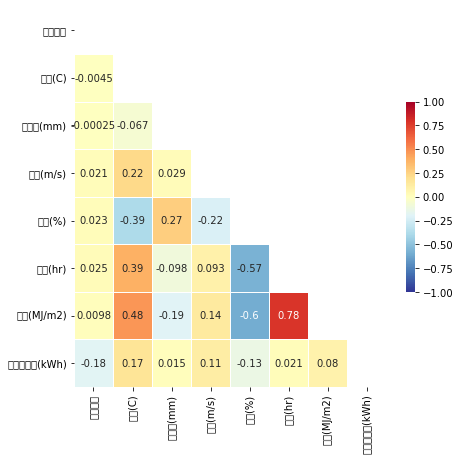

In [21]:
df = train.corr()

fig, ax = plt.subplots(figsize=(7,7))

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵
sns.heatmap(df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [22]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)', '풍속(m/s)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})

In [23]:
# 결측치 처리
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['건물번호']
                date = df.loc[i,:]['일시'][:8]
                avg_value = df[(df['건물번호'] == building_num) & (df['일시'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

# fill_missing_with_avg(train_df, '풍속')
fill_missing_with_avg(train_df, '습도')

In [24]:
## 일시 columns
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['요일'] = train_df['일시'].dt.weekday
train_df['시간'] = train_df['일시'].dt.hour
train_df['날짜'] = train_df['일시'].dt.date

train_df['sin_요일'] = np.sin(2*np.pi*(train_df['요일'])/6)
train_df['cos_요일'] = np.cos(2*np.pi*(train_df['요일'])/6)
train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)
# train_df['sin_일'] = np.sin(2*np.pi*(train_df['일']-1)/30)
# train_df['cos_일'] = np.cos(2*np.pi*(train_df['일']-1)/30)
# train_df['일수'] = train_df['일시'].dt.dayofyear

train_df['휴일'] = train_df['요일'].isin([5,6]).astype(int)
train_df.loc[(train_df['월'] == 6) & (train_df['일'] == 6), '휴일'] = 1
train_df.loc[(train_df['월'] == 8) & (train_df['일'] == 15), '휴일'] = 1

cat_month = pd.get_dummies(train_df['월'])
train_df = pd.concat([train_df, cat_month], axis = 1)

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   건물번호    204000 non-null  int64         
 1   일시      204000 non-null  datetime64[ns]
 2   기온      204000 non-null  float64       
 3   습도      204000 non-null  float64       
 4   전력소비량   204000 non-null  float64       
 5   월       204000 non-null  int64         
 6   일       204000 non-null  int64         
 7   요일      204000 non-null  int64         
 8   시간      204000 non-null  int64         
 9   날짜      204000 non-null  object        
 10  sin_요일  204000 non-null  float64       
 11  cos_요일  204000 non-null  float64       
 12  sin_시간  204000 non-null  float64       
 13  cos_시간  204000 non-null  float64       
 14  휴일      204000 non-null  int32         
 15  6       204000 non-null  uint8         
 16  7       204000 non-null  uint8         
 17  8       204000 non-null  uint

In [26]:
# train_df.set_index(train_df['일시'], inplace = True)
# train_df

In [27]:
# train_df['풍속'] = train_df['풍속'].interpolate(method = 'time')

In [28]:
# train_df['습도'] = train_df['습도'].interpolate(method = 'time')

In [29]:
# train_df['강수량'] = train_df['강수량'].interpolate(method = 'time')

In [30]:
# train_df = train_df.fillna(0)

In [31]:
# train_df.reset_index(drop = True, inplace = True)

In [32]:
# cat_month = pd.get_dummies(train_df['월'])
# train_df = pd.concat([train_df, cat_month], axis = 1).drop(columns = ['월'])

In [33]:
# 건물별, 요일별, 시간별 발전량 평균 넣어주기
weekday_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['요일별_평균'] = train_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:32<00:00, 2213.27it/s]


In [34]:
# 건물별 시간, 요일별 발전량 표준편차 넣어주기
weekday_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['요일별_표준편차'] = train_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:31<00:00, 2217.71it/s]


In [35]:
# 건물별 시간별 발전량 평균 넣어주기
hour_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['시간별_평균'] = train_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:00<00:00, 3389.69it/s]


In [36]:
# 건물별 시간별 발전량 표준편차 넣어주기
hour_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['시간별_표준편차'] = train_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

  0%|          | 0/204000 [00:00<?, ?it/s]

100%|██████████| 204000/204000 [00:59<00:00, 3448.31it/s]


In [37]:
# 파생변수 생성 - 열지수
train_df['기온(F)'] = (train_df['기온'] * 9/5) + 32
T = train_df['기온(F)']
RH = train_df['습도']
train_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# train_df['열지수'] = pd.cut(train_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])


(array([ 4423., 14707., 33221., 52404., 41295., 31996., 17516.,  7126.,
         1155.,   157.]),
 array([ 55.63234398,  61.99087681,  68.34940963,  74.70794245,
         81.06647528,  87.4250081 ,  93.78354092, 100.14207375,
        106.50060657, 112.8591394 , 119.21767222]),
 <BarContainer object of 10 artists>)

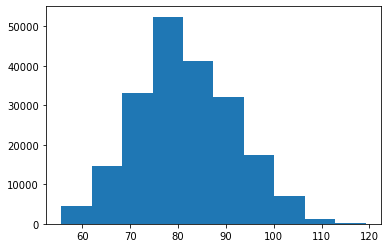

In [38]:
plt.hist(train_df['열지수'])

In [39]:
# 파생변수 생성 - 체감온도
# T = train_df['기온']
# W = train_df['풍속']
# train_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

In [40]:
# plt.hist(train_df['체감온도'])

In [41]:
# 파생변수 생성 - 불쾌지수
T = 9/5*train_df['기온']
RH = train_df['습도']
train_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])
discomfort = pd.get_dummies(train_df['불쾌지수'])
train_df = pd.concat([train_df, discomfort], axis = 1).rename(columns = {0:'불쾌지수_0', 1:'불쾌지수_1', 2:'불쾌지수_2', 3:'불쾌지수_3'})

In [42]:
train_df

,건물번호,일시,기온,습도,전력소비량,월,일,요일,시간,날짜,...,요일별_표준편차,시간별_평균,시간별_표준편차,기온(F),열지수,불쾌지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,불쾌지수_3
0,1,2022-06-01 00:00:00,18.6,42.0,1085.28,6,1,2,0,2022-06-01,...,517.982222,1706.318118,446.882767,65.48,78.408916,0,1,0,0,0
1,1,2022-06-01 01:00:00,18.0,45.0,1047.36,6,1,2,1,2022-06-01,...,500.769931,1622.620235,439.662704,64.40,79.147251,0,1,0,0,0
2,1,2022-06-01 02:00:00,17.7,45.0,974.88,6,1,2,2,2022-06-01,...,465.227458,1506.971294,412.071906,63.86,79.492837,0,1,0,0,0
3,1,2022-06-01 03:00:00,16.7,48.0,953.76,6,1,2,3,2022-06-01,...,436.601091,1437.365647,391.205981,62.06,80.948219,0,1,0,0,0
4,1,2022-06-01 04:00:00,18.4,43.0,986.40,6,1,2,4,2022-06-01,...,405.518091,1447.321412,381.099697,65.12,78.649811,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,86.0,881.04,8,24,2,19,2022-08-24,...,163.825489,1010.462118,161.399578,73.58,72.567800,1,0,1,0,0
203996,100,2022-08-24 20:00:00,22.4,86.0,798.96,8,24,2,20,2022-08-24,...,153.076049,928.125176,137.566008,72.32,70.929804,1,0,1,0,0
203997,100,2022-08-24 21:00:00,21.3,92.0,825.12,8,24,2,21,2022-08-24,...,143.415686,830.032941,128.300189,70.34,66.382661,1,0,1,0,0
203998,100,2022-08-24 22:00:00,21.0,94.0,640.08,8,24,2,22,2022-08-24,...,105.147190,723.100235,112.464079,69.80,64.810657,1,0,1,0,0


In [43]:
# 파생변수 생성 - CDH
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [44]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

(array([  113.,  1349.,  8264., 12984., 31299., 62308., 51474., 27437.,
         8151.,   621.]),
 array([10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. , 31.7, 34.4, 37.1]),
 <BarContainer object of 10 artists>)

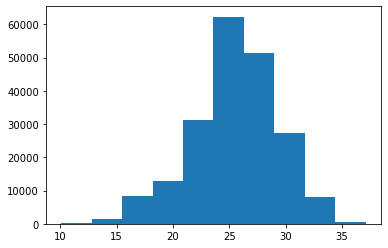

In [45]:
plt.hist(train_df['CDH'])

In [46]:
# 이상치 제거 -> 안하는게 나음
def detect_outliers(df,ratio): 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)

# for i in range(100):    
#     idx = detect_outliers(train_target[i],1.25)
#     train_target[i] = train_target[i][idx]
#     train_input[i] = train_input[i][idx]


In [47]:
train_df.columns

Index([    '건물번호',       '일시',       '기온',       '습도',    '전력소비량',        '월',
              '일',       '요일',       '시간',       '날짜',   'sin_요일',   'cos_요일',
         'sin_시간',   'cos_시간',       '휴일',          6,          7,          8,
         '요일별_평균', '요일별_표준편차',   '시간별_평균', '시간별_표준편차',    '기온(F)',      '열지수',
           '불쾌지수',   '불쾌지수_0',   '불쾌지수_1',   '불쾌지수_2',   '불쾌지수_3',      'CDH'],
      dtype='object')

In [48]:
train_df = train_df.drop(columns = ['일시', '일', '날짜', '기온(F)'])

In [49]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(12,2)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(train_df.columns[1:]):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [50]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(7,1)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(['풍속', '습도', '전력소비량', '시간별_평균', '시간별_표준편차']):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [51]:
# train_df['log_풍속'] = np.log1p(train_df['풍속'])
train_df['log_전력소비량'] = np.log1p(train_df['전력소비량'])

train_df['log_요일별_평균'] = np.log1p(train_df['요일별_평균'])
train_df['log_요일별_표준편차'] = np.log1p(train_df['요일별_표준편차'])
train_df['log_시간별_평균'] = np.log1p(train_df['시간별_평균'])
train_df['log_시간별_표준편차'] = np.log1p(train_df['시간별_표준편차'])

In [52]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(6,1)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(['log_풍속', 'log_전력소비량', 'log_시간별_평균', 'log_시간별_표준편차']):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [53]:
train_df

,건물번호,기온,습도,전력소비량,월,요일,시간,sin_요일,cos_요일,sin_시간,...,불쾌지수_0,불쾌지수_1,불쾌지수_2,불쾌지수_3,CDH,log_전력소비량,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,1,18.6,42.0,1085.28,6,2,0,0.866025,-0.5,0.000000e+00,...,1,0,0,0,18.6,6.990514,7.481975,6.251870,7.442679,6.104532
1,1,18.0,45.0,1047.36,6,2,1,0.866025,-0.5,2.697968e-01,...,1,0,0,0,18.0,6.954982,7.431506,6.218142,7.392414,6.088280
2,1,17.7,45.0,974.88,6,2,2,0.866025,-0.5,5.195840e-01,...,1,0,0,0,17.7,6.883340,7.360411,6.144674,7.318521,6.023622
3,1,16.7,48.0,953.76,6,2,3,0.866025,-0.5,7.308360e-01,...,1,0,0,0,16.7,6.861460,7.328538,6.081308,7.271263,5.971787
4,1,18.4,43.0,986.40,6,2,4,0.866025,-0.5,8.878852e-01,...,1,0,0,0,18.4,6.895075,7.318403,6.007628,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,86.0,881.04,8,2,19,0.866025,-0.5,-8.878852e-01,...,0,1,0,0,23.1,6.782237,6.873033,5.104887,6.919152,5.090060
203996,100,22.4,86.0,798.96,8,2,20,0.866025,-0.5,-7.308360e-01,...,0,1,0,0,22.4,6.684562,6.783534,5.037446,6.834243,4.931347
203997,100,21.3,92.0,825.12,8,2,21,0.866025,-0.5,-5.195840e-01,...,0,1,0,0,21.3,6.716740,6.659416,4.972696,6.722669,4.862137
203998,100,21.0,94.0,640.08,8,2,22,0.866025,-0.5,-2.697968e-01,...,0,1,0,0,21.0,6.463154,6.498685,4.664827,6.584930,4.731486


In [54]:
# plt.plot(train_df[['log_전력소비량']])
# # plt.plot(train_df[['log_요일별_평균']])
# plt.plot(train_df[['log_시간별_평균']])

In [55]:
train_df.columns

Index([        '건물번호',           '기온',           '습도',        '전력소비량',
                  '월',           '요일',           '시간',       'sin_요일',
             'cos_요일',       'sin_시간',       'cos_시간',           '휴일',
                    6,              7,              8,       '요일별_평균',
           '요일별_표준편차',       '시간별_평균',     '시간별_표준편차',          '열지수',
               '불쾌지수',       '불쾌지수_0',       '불쾌지수_1',       '불쾌지수_2',
             '불쾌지수_3',          'CDH',    'log_전력소비량',   'log_요일별_평균',
       'log_요일별_표준편차',   'log_시간별_평균', 'log_시간별_표준편차'],
      dtype='object')

In [56]:
# by_weekday = train_df.groupby(['건물번호','요일'])['전력소비량'].mean().reset_index().pivot('건물번호','요일','전력소비량').reset_index()
# by_hour = train_df.groupby(['건물번호','시간'])['전력소비량'].mean().reset_index().pivot('건물번호','시간','전력소비량').reset_index().drop('건물번호', axis = 1)
# df = pd.concat([by_weekday, by_hour], axis= 1)
# columns = ['건물번호'] + ['일'+str(i) for i in range(7)] + ['시간'+str(i) for i in range(24)]
# df.columns = columns

In [57]:
# for i in range(len(df)):
#     df.iloc[i, 1:8] = (df.iloc[i, 1:8] - df.iloc[i, 1:8].mean())/df.iloc[i, 1:8].std()
#     df.iloc[i, 8:] = (df.iloc[i, 8:] - df.iloc[i, 8:].mean())/df.iloc[i, 8:].std()


In [58]:
# # elbow 탐색
# def change_n_clusters(n_clusters, data):
#     sum_of_squared_distance = []
#     for n_cluster in n_clusters:
#         kmeans = KMeans(n_clusters=n_cluster)
#         kmeans.fit(data)
#         sum_of_squared_distance.append(kmeans.inertia_)
        
#     plt.figure(1 , figsize = (8, 5))
#     plt.plot(n_clusters , sum_of_squared_distance , 'o')
#     plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Inertia')

# change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

# # k = 5로 결정

In [59]:
# kmeans = KMeans(n_clusters = 8, random_state= 42)
# km_cluster = kmeans.fit_predict(df.iloc[:, 1:])

# df_clust = df.copy()
# df_clust['km_cluster'] = km_cluster

In [60]:
# n_c = len(np.unique(df_clust.km_cluster)) 

# grid = gridspec.GridSpec(9, 2)
# plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

# fig = plt.figure(figsize = (20, 8))
# for k in range(n_c):
#     temp = df_clust[df_clust.km_cluster == k]
#     plt.subplot(grid[2*k])
#     for i in range(len(temp)):
#         plt.plot(temp.iloc[i,1:8], linewidth=0.7)
#         plt.title(f'cluster{k}')
#         plt.xlabel('')
#         plt.xticks([])
#     plt.subplot(grid[2*k+1])
#     for i in range(len(temp)):
#         plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
#         plt.title(f'cluster{k}')
#         plt.xlabel('')
#         plt.xticks([])

In [61]:
# df_clust

In [62]:
# df_clust.to_csv('../submission/cluster.csv', index = False)

In [63]:
# plt.hist(df_clust['km_cluster'])

In [64]:
# clust = df_clust[['건물번호', 'km_cluster']]
# train_df = pd.merge(train_df, clust)

In [65]:
train_df.columns

Index([        '건물번호',           '기온',           '습도',        '전력소비량',
                  '월',           '요일',           '시간',       'sin_요일',
             'cos_요일',       'sin_시간',       'cos_시간',           '휴일',
                    6,              7,              8,       '요일별_평균',
           '요일별_표준편차',       '시간별_평균',     '시간별_표준편차',          '열지수',
               '불쾌지수',       '불쾌지수_0',       '불쾌지수_1',       '불쾌지수_2',
             '불쾌지수_3',          'CDH',    'log_전력소비량',   'log_요일별_평균',
       'log_요일별_표준편차',   'log_시간별_평균', 'log_시간별_표준편차'],
      dtype='object')

In [66]:
train_df_xg = train_df[['건물번호', 'log_전력소비량', '기온', '습도', 'sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수_0', '불쾌지수_1', '불쾌지수_2', 'CDH',
       'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차', 6, 7]]

train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df_xg[train_df_xg['건물번호'] == i])

In [67]:
# train_df_cat = train_df[['건물번호', 'log_전력소비량', '기온', '습도', '월', 'sin_요일', 'cos_요일',
#        'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수', 'CDH', 'log_풍속',
#        'log_시간별_평균', 'log_시간별_표준편차']]

# train_dfs_cat  = []
# for i in range(1,101):
#     train_dfs_cat.append(train_df_cat[train_df_cat['건물번호'] == i])       

In [68]:
for i in range(100):
    train_dfs[i] = train_dfs[i].drop(columns = ['건물번호'])

# for i in range(100):
#     train_dfs_cat[i] = train_dfs_cat[i].drop(columns = ['건물번호'])

In [69]:
# train_dfs_1[4]

In [70]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [71]:
# train_input_cat = [] 
# train_target_cat = []

# for i in range(len(train_dfs_cat)):
#     train_input_cat.append(copy.deepcopy(train_dfs_cat[i][train_dfs_cat[i].columns[1:]])) 
#     train_target_cat.append(copy.deepcopy(train_dfs_cat[i][train_dfs_cat[i].columns[0]]))

In [72]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [74]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})

## 일시 columns
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['월'] = test_df['일시'].dt.month
test_df['일'] = test_df['일시'].dt.day
test_df['요일'] = test_df['일시'].dt.weekday
test_df['시간'] = test_df['일시'].dt.hour
# test_df['날짜'] = test_df['일시'].dt.date

test_df['sin_요일'] = np.sin(2*np.pi*(test_df['요일'])/6)
test_df['cos_요일'] = np.cos(2*np.pi*(test_df['요일'])/6)
test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)
# test_df['sin_일'] = np.sin(2*np.pi*(test_df['일']-1)/30)
# test_df['cos_일'] = np.cos(2*np.pi*(test_df['일']-1)/30)
# test_df['일수'] = test_df['일시'].dt.dayofyear

test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)

# 파생변수 생성 - 열지수
test_df['기온(F)'] = (test_df['기온'] * 9/5) + 32
T = test_df['기온(F)']
RH = test_df['습도']
test_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# test_df['열지수'] = pd.cut(test_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])

# 파생변수 생성 - 체감온도
# T = test_df['기온']
# W = test_df['풍속']
# test_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

# 파생변수 생성 - 불쾌지수
T = 9/5*test_df['기온']
RH = test_df['습도']
test_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])
discomfort = pd.get_dummies(test_df['불쾌지수'])
test_df = pd.concat([test_df, discomfort], axis = 1).rename(columns = {0:'불쾌지수_0', 1:'불쾌지수_1', 2:'불쾌지수_2', 3:'불쾌지수_3'})

# 파생변수 생성 - CDH

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df['log_풍속'] = np.log1p(test_df['풍속'])

# 전력소비량 넣어주기
test_df['요일별_평균'] = test_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)
test_df['요일별_표준편차'] = test_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_평균'] = test_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_표준편차'] = test_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

test_df['log_요일별_평균'] = np.log1p(test_df['요일별_평균'])
test_df['log_요일별_표준편차'] = np.log1p(test_df['요일별_표준편차'])
test_df['log_시간별_평균'] = np.log1p(test_df['시간별_평균'])
test_df['log_시간별_표준편차'] = np.log1p(test_df['시간별_표준편차'])

test_df[6] = 0
test_df[7] = 0
test_df[6] = test_df[6].astype('uint8')
test_df[7] = test_df[7].astype('uint8')
cat_month = pd.get_dummies(test_df['월'])
test_df = pd.concat([test_df, cat_month], axis = 1)

100%|██████████| 16800/16800 [00:04<00:00, 3386.67it/s]


In [75]:
# test_df = pd.merge(test_df, clust)

In [76]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   건물번호          16800 non-null  int64         
 1   일시            16800 non-null  datetime64[ns]
 2   기온            16800 non-null  float64       
 3   풍속            16800 non-null  float64       
 4   습도            16800 non-null  int64         
 5   월             16800 non-null  int64         
 6   일             16800 non-null  int64         
 7   요일            16800 non-null  int64         
 8   시간            16800 non-null  int64         
 9   sin_요일        16800 non-null  float64       
 10  cos_요일        16800 non-null  float64       
 11  sin_시간        16800 non-null  float64       
 12  cos_시간        16800 non-null  float64       
 13  휴일            16800 non-null  int32         
 14  기온(F)         16800 non-null  float64       
 15  열지수           16800 non-null  float6

In [77]:
test_df_xg = test_df[['건물번호', '기온', '습도', 'sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수_0', '불쾌지수_1', '불쾌지수_2', 'CDH',
       'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차', 6, 7]]

test_input = []
for i in range(1,101):
    test_input.append(test_df_xg[test_df_xg['건물번호']==i])

for i in range(100):
    test_input[i] = test_input[i].drop(columns = ['건물번호'])

# test_df_cat = test_df[['건물번호', '기온', '습도', '월', 'sin_요일', 'cos_요일',
#        'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수', 'CDH', 'log_풍속',
#        'log_시간별_평균', 'log_시간별_표준편차']]

# test_input_cat  = []
# for i in range(1, 101):
#     test_input_cat.append(test_df_cat[test_df_cat['건물번호']==i])

# for i in range(100):
#     test_input_cat[i] = test_input_cat[i].drop(columns = ['건물번호'])


In [78]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(12,2)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(test_df.columns):
#     ax = plt.subplot(grid[idx])
#     plt.hist(test_df[feature])
#     plt.title(f"{feature}")

In [79]:
display(train_input[0])
display(test_input[0])
# display(train_input_cat[0])
# display(test_input_cat[0])

,기온,습도,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차,6,7
0,18.6,42.0,0.866025,-0.5,0.000000e+00,1.000000,0,78.408916,1,0,0,18.6,7.481975,6.251870,7.442679,6.104532,1,0
1,18.0,45.0,0.866025,-0.5,2.697968e-01,0.962917,0,79.147251,1,0,0,18.0,7.431506,6.218142,7.392414,6.088280,1,0
2,17.7,45.0,0.866025,-0.5,5.195840e-01,0.854419,0,79.492837,1,0,0,17.7,7.360411,6.144674,7.318521,6.023622,1,0
3,16.7,48.0,0.866025,-0.5,7.308360e-01,0.682553,0,80.948219,1,0,0,16.7,7.328538,6.081308,7.271263,5.971787,1,0
4,18.4,43.0,0.866025,-0.5,8.878852e-01,0.460065,0,78.649811,1,0,0,18.4,7.318403,6.007628,7.278161,5.945682,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,63.0,0.866025,-0.5,-8.878852e-01,0.460065,0,79.681361,0,1,0,25.5,7.852622,5.950292,7.902810,5.936241,0,0
2036,25.0,66.0,0.866025,-0.5,-7.308360e-01,0.682553,0,78.797002,0,1,0,25.0,7.779897,6.003982,7.821234,5.879386,0,0
2037,24.6,67.0,0.866025,-0.5,-5.195840e-01,0.854419,0,78.058634,0,1,0,24.6,7.543777,5.492728,7.587466,5.383027,0,0
2038,24.1,70.0,0.866025,-0.5,-2.697968e-01,0.962917,0,77.031069,0,1,0,24.1,7.254080,4.662324,7.295769,4.753586,0,0


,기온,습도,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차,6,7
0,23.5,72,1.224647e-16,-1.0,0.000000e+00,1.000000,0,75.835980,0,1,0,23.5,7.395599,6.104760,7.442679,6.104532,0,0
1,23.0,72,1.224647e-16,-1.0,2.697968e-01,0.962917,0,75.097159,0,1,0,23.0,7.346707,6.109451,7.392414,6.088280,0,0
2,22.7,75,1.224647e-16,-1.0,5.195840e-01,0.854419,0,74.149922,0,1,0,22.7,7.266911,6.031775,7.318521,6.023622,0,0
3,22.1,78,1.224647e-16,-1.0,7.308360e-01,0.682553,0,72.636805,0,1,0,22.1,7.224899,5.937847,7.271263,5.971787,0,0
4,21.8,77,1.224647e-16,-1.0,8.878852e-01,0.460065,0,72.533716,0,1,0,21.8,7.231808,5.889843,7.278161,5.945682,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,75,8.660254e-01,-0.5,-8.878852e-01,0.460065,0,75.442391,0,1,0,23.5,7.852622,5.950292,7.902810,5.936241,0,0
164,22.4,80,8.660254e-01,-0.5,-7.308360e-01,0.682553,0,72.571571,0,1,0,22.4,7.779897,6.003982,7.821234,5.879386,0,0
165,21.7,81,8.660254e-01,-0.5,-5.195840e-01,0.854419,0,71.235792,0,1,0,21.7,7.543777,5.492728,7.587466,5.383027,0,0
166,21.1,83,8.660254e-01,-0.5,-2.697968e-01,0.962917,0,69.774703,0,1,0,21.1,7.254080,4.662324,7.295769,4.753586,0,0


In [87]:
submission = pd.read_csv('../dataset/sample_submission.csv')

In [81]:
K = [i for i in [5]]
catfeatures = ['월', '휴일', '불쾌지수']
random_seed = 42


In [82]:
# preds = pd.DataFrame(index = range(0, 16800), columns = {'cat', 'lgb', 'xgb'})

In [83]:
# cat_mae_params = {
#     'objective': 'MAE',
#     'n_estimators': 10000, 
#     'cat_features' : catfeatures,
#     'one_hot_max_size' : 5
# } # catboost hyper parameter

# for k in K: # kfold 의 nspilt 의 값 k
#     folds = []
#     for i in range(len(train_dfs_cat)):
#         cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
#         fold = []
#         for train_idx, valid_idx in cross.split(train_input_cat[i], train_target_cat[i]):
#             fold.append((train_idx, valid_idx))
#         folds.append(fold)
            
#     for i in range(len(train_dfs_cat)):
#         for fold in range(k):
#             print(random_seed, k, i)
#             train_idx, valid_idx = folds[i][fold]
#             X_train = train_input_cat[i].iloc[train_idx]
#             y_train = train_target_cat[i].iloc[train_idx]
#             X_valid = train_input_cat[i].iloc[valid_idx]
#             y_valid = train_target_cat[i].iloc[valid_idx]                
#             # catboost 학습 
#             model = CatBoostRegressor(**cat_mae_params)
#             model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
#             v = (np.exp(model.predict(test_input_cat[i][train_input_cat[i].columns]))-1)
            
#             preds['cat'].iloc[(i)*168:(i+1)*168] = v/(len(K)*k)
#             clear_output(True)

In [84]:
# lgbm_mae_params = {
#     'objective': 'MAE',
#     'boosting_type': 'goss',
#     'n_estimators': 10000, 
#     'num_leaves':39,
#     'categorical_feature = name' : catfeatures
# } # lightgbm hyper parameter

# for k in K: # kfold 의 nspilt 의 값 k
#     folds = []
#     for i in range(len(train_dfs_cat)):
#         cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
#         fold = []
#         for train_idx, valid_idx in cross.split(train_input_cat[i], train_target_cat[i]):
#             fold.append((train_idx, valid_idx))
#         folds.append(fold)
            
#     for i in range(len(train_dfs_cat)):
#         for fold in range(k):
#             print(random_seed, k, i)
#             train_idx, valid_idx = folds[i][fold]
#             X_train = train_input_cat[i].iloc[train_idx]
#             y_train = train_target_cat[i].iloc[train_idx]
#             X_valid = train_input_cat[i].iloc[valid_idx]
#             y_valid = train_target_cat[i].iloc[valid_idx]               
                
#             #lgbm 학습 
#             model=LGBMRegressor(**lgbm_mae_params)
#             model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
#             v = (np.exp(model.predict(test_input_cat[i][train_input_cat[i].columns]))-1) * 1

#             preds['lgb'].iloc[(i)*168:(i+1)*168] = v/(len(K)*k)
#             clear_output(True)

In [88]:
xgboost_params = {
    'objective':'reg:linear',
    'eval_metric' : 'rmse',
    'n_estimators':1000,
    'seed':random_seed,
    'min_child_weight':1,
    'eta':0.1,
    'gamma':0,
    'max_depth':6,
    'sub_sample':1,
    'colsample_bytree' : 1,
    'lambda':1,
    'alpha':0,
    'scale_pos_weight':1,
}

for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)
            
    for i in range(len(train_dfs)):
        for fold in range(k):
            print(random_seed, k, i)
            train_idx, valid_idx = folds[i][fold]
            X_train = train_input[i].iloc[train_idx]
            y_train = train_target[i].iloc[train_idx]
            X_valid = train_input[i].iloc[valid_idx]
            y_valid = train_target[i].iloc[valid_idx]                

            # xgboost 학습
            model = XGBRegressor(**xgboost_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 1
    
            submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k)
            clear_output(True)

42 5 99
[19:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

[0]	validation_0-rmse:5.54680
[1]	validation_0-rmse:4.99469
[2]	validation_0-rmse:4.49776
[3]	validation_0-rmse:4.05048
[4]	validation_0-rmse:3.64824
[5]	validation_0-rmse:3.28577
[6]	validation_0-rmse:2.95965
[7]	validation_0-rmse:2.66637
[8]	validation_0-rmse:2.40143
[9]	validation_0-rmse:2.16386
[10]	validation_0-rmse:1.94968
[11]	validation_0-rmse:1.75719
[12]	validation_0-rmse:1.58289
[13]	validation_0-rmse:1.42678
[14]	validation_0-rmse:1.28663
[15]	validation_0-rmse:1.16024
[16]	validation_0-rmse:1.04595
[17]	validation_0-rmse:0.94329
[18]	validati

In [94]:
submission['answer'] = np.round(submission['answer'], 2)

In [90]:
submission.to_csv('../submission/answer17.csv', index = False)

In [91]:
best = pd.read_csv('../submission/answer15.csv')
update = pd.read_csv('../submission/answer17.csv')

In [92]:
display(best)
display(update)

,num_date_time,answer
0,1_20220825 00,1925.136642
1,1_20220825 01,1893.762909
2,1_20220825 02,1788.864182
3,1_20220825 03,1615.842499
4,1_20220825 04,1625.564178
...,...,...
16795,100_20220831 19,899.154694
16796,100_20220831 20,795.610718
16797,100_20220831 21,710.113541
16798,100_20220831 22,631.441547


,num_date_time,answer
0,1_20220825 00,2045.561829
1,1_20220825 01,1818.684753
2,1_20220825 02,1652.104126
3,1_20220825 03,1525.554962
4,1_20220825 04,1556.443024
...,...,...
16795,100_20220831 19,870.764130
16796,100_20220831 20,814.672058
16797,100_20220831 21,724.532318
16798,100_20220831 22,615.804504


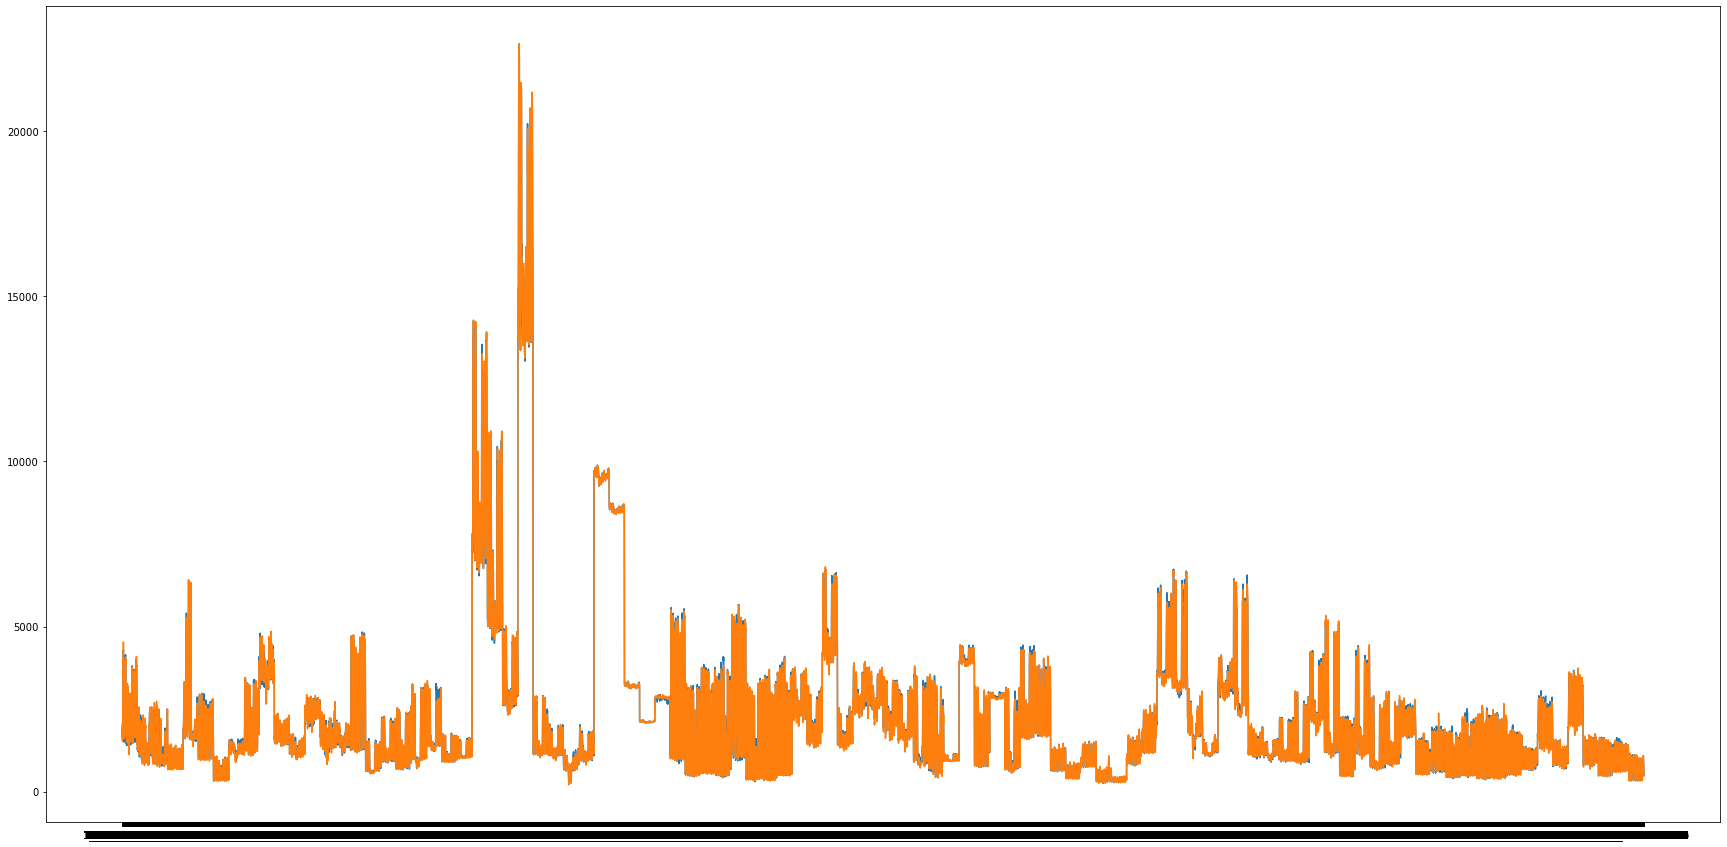

In [93]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])


x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)